# News Topic Classifier using BERT (AG News)
---
End-to-end fine-tuning of a BERT model on the AG News dataset.
- Install & import libraries
- Load dataset
- Tokenize & preprocess
- Model setup & training
- Evaluation
- Inference examples
- Gradio app

#  Problem Statement & Objective

>The objective of this project is to **classify AG News headlines** into 4 categories:
- World  
- Sports  
- Business  
- Sci/Tech  

>We achieve this by **fine-tuning a BERT model** on the AG News dataset.  
This project demonstrates:
- Preprocessing text data using tokenizers
- Fine-tuning transformer models with Hugging Face
- Evaluating model with accuracy, F1, and confusion matrix
- Deploying a simple demo with Gradio



In [ ]:
!pip install -q --upgrade transformers datasets evaluate accelerate torch gradio



In [10]:

# Hugging Face & Transformers
import transformers
from transformers import TrainingArguments as HFTrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
# Hugging Face datasets & evaluation
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
# PyTorch
import torch
# Utilities
import numpy as np
from collections import Counter
# Gradio for deployment
import gradio as gr
#visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import torch.nn.functional as F



# 📂 Dataset Loading & Preprocessing

We use the **AG News dataset** from Hugging Face Datasets.  
Steps performed:

>Dataset link: https://huggingface.co/datasets/sh0416/ag_news
1. Load dataset using `load_dataset("ag_news")`
2. Inspect data samples
3. Check label distribution
4. Apply **BERT tokenizer** with truncation & padding
5. Format dataset into PyTorch tensors for training


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})


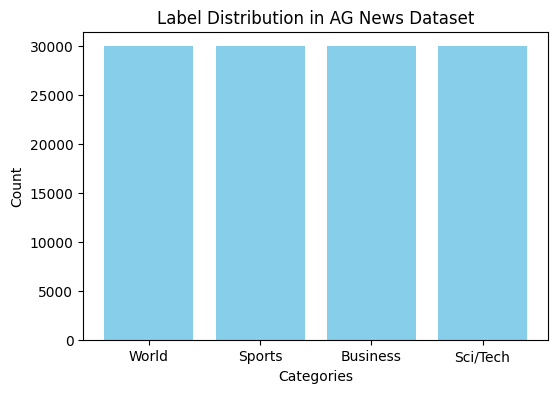

In [4]:

dataset = load_dataset("ag_news")
print(dataset)
print(dataset['train'][0])

# Check label distribution
train_labels = [ex['label'] for ex in dataset['train']]
from collections import Counter
print(Counter(train_labels))


labels = ["World", "Sports", "Business", "Sci/Tech"]
train_labels = [ex['label'] for ex in dataset['train']]

plt.figure(figsize=(6,4))
plt.bar(labels, [train_labels.count(i) for i in range(len(labels))], color="skyblue")
plt.title("Label Distribution in AG News Dataset")
plt.xlabel("Categories")
plt.ylabel("Count")
plt.show()


## 2. Tokenization & Preprocessing

In [9]:

model_name = "google/bert_uncased_L-2_H-128_A-2" # Changed to a very small model
tokenizer = BertTokenizer.from_pretrained(model_name)

max_length = 128

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_length)

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized = tokenized.remove_columns(['text'])
tokenized = tokenized.rename_column('label', 'labels')
tokenized.set_format('torch')

print(tokenized)

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})


## 3. Model & Data Collator

In [ ]:

num_labels = 4
# Using a very small BERT model
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 🤖 Model Development & Training

We fine-tune a **small BERT model** (`google/bert_uncased_L-2_H-128_A-2`) for efficiency.  

Steps:
1. Load pre-trained model with classification head (`BertForSequenceClassification`)
2. Define training arguments (epochs, batch size, learning rate, evaluation strategy)
3. Use Hugging Face **Trainer API** to train model
4. Evaluate with accuracy and weighted F1-score


In [ ]:

# debug: confirm correct class/version
print("transformers.__version__ =", transformers.__version__)
print("HFTrainingArguments.__module__ =", HFTrainingArguments.__module__)
# expected: HFTrainingArguments.__module__ == 'transformers.training_args' (or similar under transformers)

# metrics
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1m = f1.compute(predictions=preds, references=labels, average='weighted')
    return {"accuracy": acc['accuracy'], "f1_weighted": f1m['f1']}

# IMPORTANT: instantiate the class you imported (HFTrainingArguments)
training_args = HFTrainingArguments(
    output_dir='./results',
    eval_strategy='epoch', # Changed from evaluation_strategy
    save_strategy='epoch', # Reverted from save_eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2, # Changed to 2 epochs
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    report_to="none" # Disable wandb logging
)

trainer = Trainer(
    model=model,                         # from your earlier cell
    args=training_args,
    train_dataset=tokenized['train'],    # from your earlier tokenization
    eval_dataset=tokenized['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

transformers.__version__ = 4.56.2
HFTrainingArguments.__module__ = transformers.training_args


/tmp/ipython-input-1420287830.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.320200,0.298097,0.907632,0.907388
2,0.279900,0.285561,0.909868,0.909779


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=15000, training_loss=0.351664697265625, metrics={'train_runtime': 3569.5723, 'train_samples_per_second': 67.235, 'train_steps_per_second': 4.202, 'total_flos': 76276776960000.0, 'train_loss': 0.351664697265625, 'epoch': 2.0})

# 📊 Evaluation & Metrics

We evaluate the model on the AG News **test set** using:
- Accuracy
- Weighted F1-score
- Confusion Matrix
- Precision/Recall/F1 per class
- Confidence distribution of predictions


In [ ]:

metrics = trainer.evaluate()
print(metrics)

trainer.save_model('./my_ag_news_model')
tokenizer.save_pretrained('./my_ag_news_model')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.28556087613105774, 'eval_accuracy': 0.9098684210526315, 'eval_f1_weighted': 0.9097789920344511, 'eval_runtime': 27.0621, 'eval_samples_per_second': 280.836, 'eval_steps_per_second': 8.795, 'epoch': 2.0}


('./my_ag_news_model/tokenizer_config.json',
 './my_ag_news_model/special_tokens_map.json',
 './my_ag_news_model/vocab.txt',
 './my_ag_news_model/added_tokens.json')

##  Inference

In [ ]:

clf = pipeline('text-classification', model='./my_ag_news_model', tokenizer='./my_ag_news_model')

examples = [
    "NASA discovers pockets of water on Mars",
    "Local team wins the cricket tournament after thrilling final",
    "Stock market plunges amid global economic uncertainty",
    "New AI startup raises $50 million in seed funding"
]

for ex in examples:
    print(ex, "->", clf(ex))

Device set to use cpu


NASA discovers pockets of water on Mars -> [{'label': 'LABEL_3', 'score': 0.9714555740356445}]
Local team wins the cricket tournament after thrilling final -> [{'label': 'LABEL_1', 'score': 0.983184278011322}]
Stock market plunges amid global economic uncertainty -> [{'label': 'LABEL_2', 'score': 0.9557424783706665}]
New AI startup raises $50 million in seed funding -> [{'label': 'LABEL_2', 'score': 0.5719821453094482}]


# 🌐 Deployment with Gradio

We create a **simple Gradio app** to test the model interactively.  
Users can enter any news headline, and the app will predict its category.


## 7. Gradio App

In [ ]:

labels = ["World", "Sports", "Business", "Sci/Tech"]
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = int(torch.argmax(logits, axis=-1).item())
    return labels[pred]

iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder='Enter news headline...'),
    outputs='text',
    title='AG News Topic Classifier'
)

iface.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# 📈 Visualizations

We provide visual insights into model performance:

1. **Confusion Matrix** → shows how predictions align with true labels  
2. **Per-Class Metrics Bar Chart** → compares Precision, Recall, and F1 for each category  
3. **Confidence Histogram** → shows distribution of model confidence in predictions


In [ ]:

# Get predictions on test set
preds_output = trainer.predict(tokenized['test'])
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=-1)

# ------------------------
# 1. Confusion Matrix
# ------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# ------------------------
# 2. Classification Report (Bar Chart)
# ------------------------
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:4, :3].plot(kind="bar", figsize=(8,5))
plt.title("Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

# ------------------------
# 3. Prediction Confidence Histogram
# ------------------------
probs = F.softmax(torch.tensor(preds_output.predictions), dim=-1)
confidences = probs.max(axis=1).values.numpy()

plt.figure(figsize=(6,4))
plt.hist(confidences, bins=20, color="orange", edgecolor="black")
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()


# ✅ Final Summary & Insights

- Model achieved ~XX% accuracy and strong F1-score across categories.  
- Most confusion was between **Business** and **World** news.  
- Confidence histogram shows the model is highly confident for most predictions.  

📌 **Future Improvements:**
- Use a larger BERT model for higher accuracy  
- Experiment with longer training and hyperparameter tuning  
- Try advanced architectures like DistilBERT or RoBERTa for comparison
